In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os
datadir = 'F:/crs/proj/2025_NOPP_comparison/helene_water_level/DesignSafe/'
wg_file = '2024-Sept-30_RAPID-WG04_Data.CSV'

In [2]:
def nheri_rwg_read_csv(filename):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(filename)
    
    # Combine the 'Date' and 'Time (GMT)' columns into a single 'time' column
    df['time'] = pd.to_datetime(df['date'] + ' ' + df[' time'])
    
    # Drop the original 'Date' and 'Time (GMT)' columns and other unnecessary columns
    # (note the annoying leading space for column names)
    df.drop(columns=["date", " time"], inplace=True)

    df.rename(columns={' pressure': 'pressure'}, inplace=True)
    
    # Initialize variables to track the current second and the number of records for that second
    current_second = None
    records_in_current_second = 0
    timestamps = []
    
    # Set the base time as the time of the first record
    base_time = df['time'].iloc[0]  # Base time is the timestamp of the first record
    
    # Iterate through the records to assign fractional timestamps
    for i, row in df.iterrows():
        record_time = row['time']
        
        # If the second has changed, process the previous second
        if current_second is None or (record_time - current_second).seconds >= 1:
            # If we're already processing a second, assign fractional timestamps to it
            if current_second is not None:
                time_increment = 1 / records_in_current_second  # Fraction of second
                for j in range(records_in_current_second):
                    fractional_time = base_time + pd.Timedelta(seconds=j * time_increment)
                    timestamps.append(fractional_time)
            
            # Update current_second and reset the records counter for the new second
            current_second = record_time
            base_time = record_time  # Set the base time for the new second
            records_in_current_second = 0
        
        # Increment the counter for records in the current second
        records_in_current_second += 1
    
    # After the loop, process the last second's records
    if current_second is not None:
        time_increment = 1 / records_in_current_second
        for j in range(records_in_current_second):
            fractional_time = base_time + pd.Timedelta(seconds=j * time_increment)
            timestamps.append(fractional_time)
    
    # Add the calculated timestamps to the dataframe
    df['timestamp'] = timestamps
    
    return df

In [17]:
# Process the test data to check time steps
# This file is short and several records have been removed
df = nheri_rwg_read_csv(datadir+'nheri_rwg_fix_timing_test_data_intput.csv')
# Drop the original 'time' column
df.drop(columns=['time'], inplace=True)

# Save the resulting DataFrame to a .csv file
output_file = "nheri_rwg_fix_timing_test_output.csv"
df.to_csv(output_file, index=False)

In [4]:
# Read a full file, remove very high
df = nheri_rwg_read_csv(datadir+wg_file)

In [5]:
df

,pressure,time,timestamp
0,1004.8,2024-09-25 08:00:03,2024-09-25 08:00:03.000000000
1,1004.6,2024-09-25 08:00:03,2024-09-25 08:00:03.062500000
2,1004.9,2024-09-25 08:00:03,2024-09-25 08:00:03.125000000
3,1004.8,2024-09-25 08:00:03,2024-09-25 08:00:03.187500000
4,1004.8,2024-09-25 08:00:03,2024-09-25 08:00:03.250000000
...,...,...,...
7219909,1003.4,2024-09-30 14:39:15,2024-09-30 14:39:15.642857142
7219910,1003.4,2024-09-30 14:39:15,2024-09-30 14:39:15.714285714
7219911,1003.4,2024-09-30 14:39:15,2024-09-30 14:39:15.785714285
7219912,1003.3,2024-09-30 14:39:15,2024-09-30 14:39:15.857142857


In [6]:
def smooth_pressure_data(df, window=5):
    """
    Applies a running mean to the 'pressure' column of the dataframe,
    without introducing a lag.
    """
    dfs = df.copy()
    dfs['pressure'] = dfs['pressure'].rolling(window=window, center=True).mean()
    return dfs

In [7]:
dfs = smooth_pressure_data(df, window=3)
dfs

,pressure,time,timestamp
0,NaN,2024-09-25 08:00:03,2024-09-25 08:00:03.000000000
1,1004.766667,2024-09-25 08:00:03,2024-09-25 08:00:03.062500000
2,1004.766667,2024-09-25 08:00:03,2024-09-25 08:00:03.125000000
3,1004.833333,2024-09-25 08:00:03,2024-09-25 08:00:03.187500000
4,1004.800000,2024-09-25 08:00:03,2024-09-25 08:00:03.250000000
...,...,...,...
7219909,1003.400000,2024-09-30 14:39:15,2024-09-30 14:39:15.642857142
7219910,1003.400000,2024-09-30 14:39:15,2024-09-30 14:39:15.714285714
7219911,1003.366667,2024-09-30 14:39:15,2024-09-30 14:39:15.785714285
7219912,1003.300000,2024-09-30 14:39:15,2024-09-30 14:39:15.857142857


In [8]:
def resample_data(df, freq='0.25s'):
    """
    Resamples the 'pressure' data to a new time series with a freq (default: 4 samples per second
    i.e., every 0.25 seconds) using linear interpolation in time.
    """
    dfc = df.copy()
    # Generate a new time index at 0.25 second intervals starting from the first timestamp
    new_time_index = pd.date_range(start=dfc['timestamp'].iloc[0], end=dfc['timestamp'].iloc[-1], freq=freq)
    
    # Create a new DataFrame with the new time index, reindexing the existing data
    df_resampled = dfc.set_index('timestamp').reindex(new_time_index)

    # Perform linear interpolation to fill in the NaN values for 'pressure'
    df_resampled['pressure'] = df_resampled['pressure'].interpolate(method='linear')

    # Reset the index, making 'timestamp' a column again
    df_resampled.reset_index(inplace=True)
    df_resampled.rename(columns={'index': 'timestamp'}, inplace=True)
    
    return df_resampled

In [9]:
dfr = resample_data(dfs, freq='0.125s')
dfr

,timestamp,pressure,time
0,2024-09-25 08:00:03.000,NaN,2024-09-25 08:00:03
1,2024-09-25 08:00:03.125,1004.766667,2024-09-25 08:00:03
2,2024-09-25 08:00:03.250,1004.800000,2024-09-25 08:00:03
3,2024-09-25 08:00:03.375,1004.733333,2024-09-25 08:00:03
4,2024-09-25 08:00:03.500,1004.700000,2024-09-25 08:00:03
...,...,...,...
3647619,2024-09-30 14:39:15.375,1003.350000,NaT
3647620,2024-09-30 14:39:15.500,1003.333333,2024-09-30 14:39:15
3647621,2024-09-30 14:39:15.625,1003.333333,NaT
3647622,2024-09-30 14:39:15.750,1003.333333,NaT


In [10]:
def df_to_xarray_and_save(df, output_nc_file):
    """
    Convert a pandas DataFrame to an xarray Dataset and save it as a .nc file.
    
    Parameters:
    df (pd.DataFrame): Input pandas DataFrame with 'timestamp' and 'pressure' columns
    output_nc_file (str): The path where the .nc file will be saved
    """
    # Convert the 'timestamp' column to a pandas datetime index
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Convert the pandas DataFrame to an xarray Dataset
    # We use 'timestamp' as the coordinate and 'pressure' as the variable
    ds = xr.Dataset(
        {
            'pressure': (['time'], df['pressure'].values)
        },
        coords={
            'time': df['timestamp'].values
        }
    )
    
    # Save the xarray Dataset as a .nc file
    ds.to_netcdf(output_nc_file)

    print(f"NetCDF file saved to: {output_nc_file}")

# Write the dataframe to an xarray dataset
output_nc_file = "resampled_data.nc"
df_to_xarray_and_save(dfr, output_nc_file)


NetCDF file saved to: resampled_data.nc


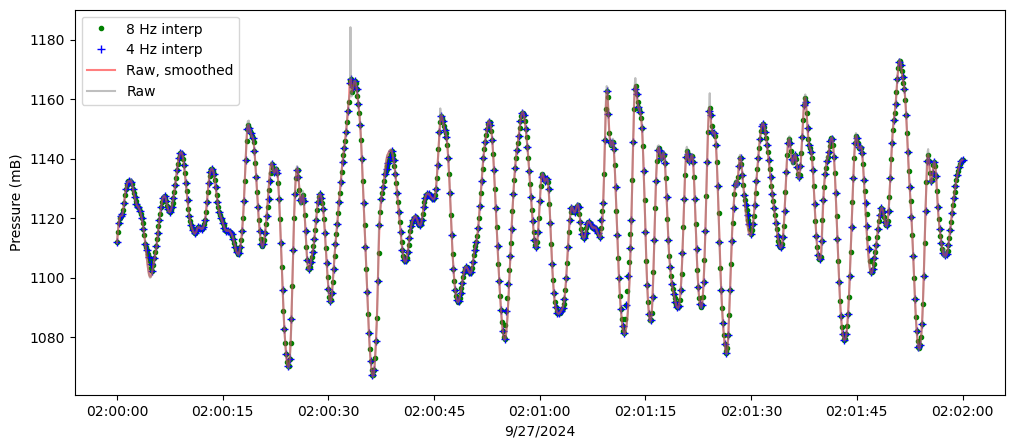

In [15]:
dfs = smooth_pressure_data(df, window=5)
dfr8 = resample_data(dfs, freq='0.125s')
dfr4 = resample_data(dfs, freq='0.25s')

start_time = '2024-09-27 02:00:00'
end_time = '2024-09-27 02:02:00'

df_short = df[(df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)]
dfr4_short = dfr4[(dfr4['timestamp'] >= start_time) & (dfr4['timestamp'] <= end_time)]
dfr8_short = dfr8[(dfr8['timestamp'] >= start_time) & (dfr8['timestamp'] <= end_time)]

dfs_short = dfs[(dfs['timestamp'] >= start_time) & (dfs['timestamp'] <= end_time)]

fig, ax = plt.subplots(1,1, figsize=(12,5) )
plt.plot(dfr8_short['timestamp'], dfr8_short['pressure'], '.g',label='8 Hz interp')
plt.plot(dfr4_short['timestamp'], dfr4_short['pressure'], '+b',label='4 Hz interp')

plt.plot(dfs_short['timestamp'], dfs_short['pressure'], '-r', alpha=.5,label='Raw, smoothed')
plt.plot(df_short['timestamp'], df_short['pressure'], '-',c='gray',alpha=.5, label='Raw')
plt.ylabel('Pressure (mB)')
plt.xlabel('9/27/2024')
plt.legend()
plt.savefig(
plt.show()
